In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import re
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/imdb-dataset-sentiment-analysis/IMDB_dataset.csv


# Load the dataset

In [2]:
dataset = pd.read_csv('/kaggle/input/imdb-dataset-sentiment-analysis/IMDB_dataset.csv')

In [3]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# The number of columns and rows in the dataset
print(f"{dataset.shape[0]} rows and {dataset.shape[1]} columns in the dataset.")

50000 rows and 2 columns in the dataset.


In [5]:
dataset.columns

Index(['review', 'sentiment'], dtype='object')

# Text Pre-processing

In [6]:
dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
dataset.isnull().sum()

review       0
sentiment    0
dtype: int64

In [9]:
dataset['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [10]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [11]:
lm = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [12]:
df = dataset.sample(5000, random_state=42)

In [13]:
df = df.dropna()

In [14]:
def transform_data(review):
    review = review.lower()
    review = re.sub('^a-zA-Z0-9', ' ', review)
    review = re.sub('<.*?>', ' ', review)
    review = "".join([x for x in review if x not in string.punctuation])
    review = review.split()
    review = [lm.lemmatize(x) for x in review if x not in stop_words]
    review = " ".join(review)
    return review


tranformed_rev = df.review.apply(transform_data)

In [15]:
df.head()

,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative


In [16]:
tranformed_rev

33553    really liked summerslam due look arena curtain...
9427     many television show appeal quite many differe...
199      film quickly get major chase scene ever increa...
12447    jane austen would definitely approve one gwyne...
39489    expectation somewhat high went see movie thoug...
                               ...                        
39885    one eastwoods best movie separated western goo...
17566    blurred childhood memory kept echo cult serie ...
16062    love zombiemovies love amateurproductions meat...
48445    chan new york get involved attempt sabotage ne...
20382    wife thought film watereddown madefortv bbc ve...
Name: review, Length: 5000, dtype: object

# Data Visualization

In [17]:
transformed_data = pd.DataFrame({
    "t_rev": tranformed_rev,
    "sentiment": df['sentiment']
})

In [18]:
transformed_data.head()

,t_rev,sentiment
33553,really liked summerslam due look arena curtain...,positive
9427,many television show appeal quite many differe...,positive
199,film quickly get major chase scene ever increa...,negative
12447,jane austen would definitely approve one gwyne...,positive
39489,expectation somewhat high went see movie thoug...,negative


## Positive Sentiment

In [19]:
tokens = str(
    list(transformed_data[transformed_data.sentiment == 'positive'].t_rev)
).split()

In [20]:
pos_words = (" ").join(tokens)

In [21]:
from wordcloud import WordCloud

wc = WordCloud(height=800, width=1200).generate(pos_words)

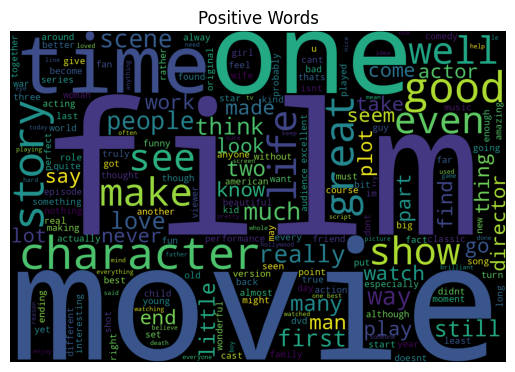

In [22]:
plt.imshow(wc)
plt.title("Positive Words")
plt.axis("off")
plt.show()

In [23]:
positive_words_frequency = Counter(tokens)

In [24]:
ps_f = positive_words_frequency.most_common(30)

In [25]:
data = pd.DataFrame(
    ps_f,
    columns=['word', 'freq']
).sort_values('freq', ascending=False)

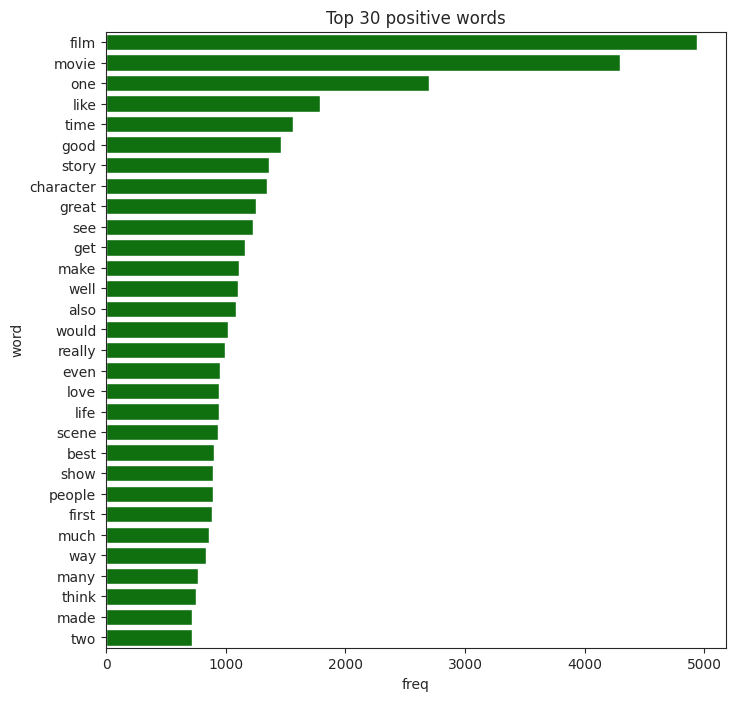

In [26]:
plt.figure(figsize=(8, 8))
sns.set_style("ticks")
sns.barplot(x="freq", y='word', data=data, color='g').set(
    title='Top 30 positive words')

plt.show()

## Negative Sentiment

In [27]:
tokens = str(
    list(transformed_data[transformed_data.sentiment == 'negative'].t_rev)
).split()

In [28]:
neg_words = (" ").join(tokens)

In [29]:
wc = WordCloud(height=800, width=1200).generate(neg_words)

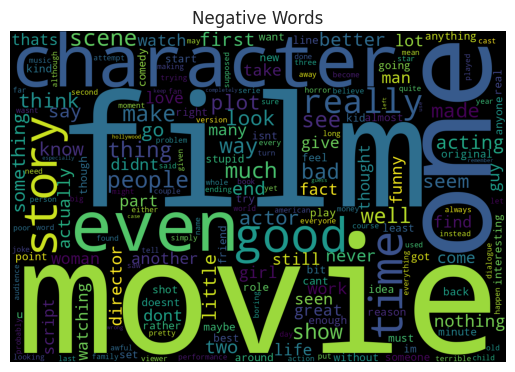

In [30]:
plt.imshow(wc)
plt.title("Negative Words")
plt.axis("off")
plt.show()

In [31]:
negative_words_frequency = Counter(tokens)

In [32]:
neg_f = negative_words_frequency.most_common(30)

In [33]:
data = pd.DataFrame(
    neg_f,
    columns=['word', 'freq']
).sort_values('freq', ascending=False)

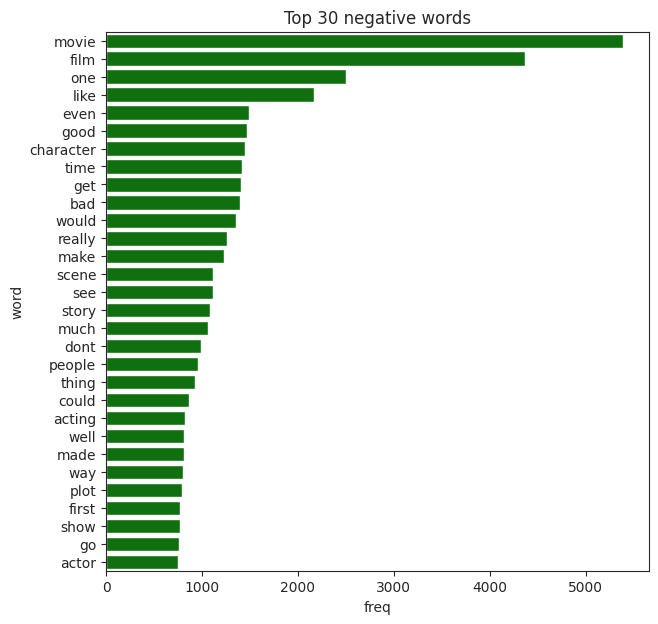

In [34]:
plt.figure(figsize=(7, 7))

sns.barplot(
    x="freq",
    y='word',
    data=data,
    color='g'
).set(title='Top 30 negative words')

plt.show()

# Spliting the dataset into training and testing

In [35]:
tf = TfidfVectorizer()
cv = CountVectorizer()

In [36]:
lb = LabelEncoder()
X = tf.fit_transform(tranformed_rev).toarray()
y = lb.fit_transform(df.sentiment)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Selecting Model

In [38]:
models = {'lr': LogisticRegression(),
          'rf': RandomForestClassifier(),
          'gs': GaussianNB(),
          'knn': KNeighborsClassifier(),
          'xgb': XGBClassifier()
          }

In [39]:
# train dataset fit and predict output
def fit_predict(models, X_train, y_trian, X_test, y_test):
    y_pred = []
    models_name = []
    for model_name, model_obj in models.items():
        model_obj.fit(X_train, y_trian)
        print(f'{model_name} done....')
        y_pred.append(model_obj.predict(X_test))
        models_name.append(model_name)
    return y_pred, models_name

# Accuracy function
def get_score(y_pred, y_test):
    score = [accuracy_score(y_test, y) for y in y_pred]
    return score

In [40]:
y_pred, models_name = fit_predict(models, X_train, y_train, X_test, y_test)

lr done....
rf done....
gs done....
knn done....
xgb done....


In [41]:
score = get_score(y_pred, y_test)

In [42]:
md_scores = pd.DataFrame({'models': models_name, 'score': score}).sort_values(
    "score", ascending=False)

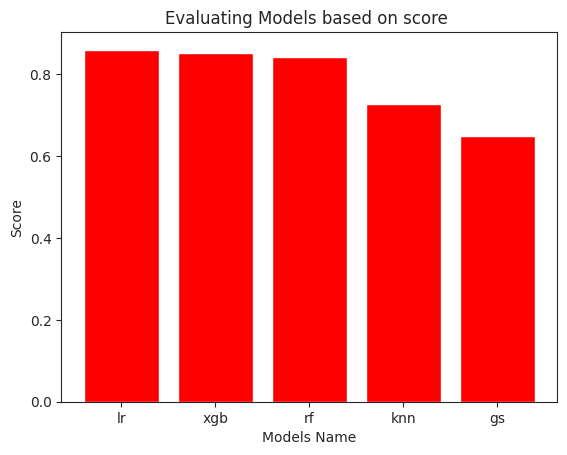

In [43]:
plt.bar('models', 'score', color='red', data=md_scores)
plt.title('Evaluating Models based on score ')
plt.xlabel('Models Name')
plt.ylabel('Score')
plt.show()

# Finally select the model: LogisticRegression

In [44]:
lr = LogisticRegression(C=14, penalty='l2', solver='newton-cg', max_iter=800, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=14, max_iter=800, random_state=42, solver='newton-cg')

In [45]:
y_pred = lr.predict(X_test)

In [46]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[425,  71],
       [ 67, 437]])

# Model Evaluation

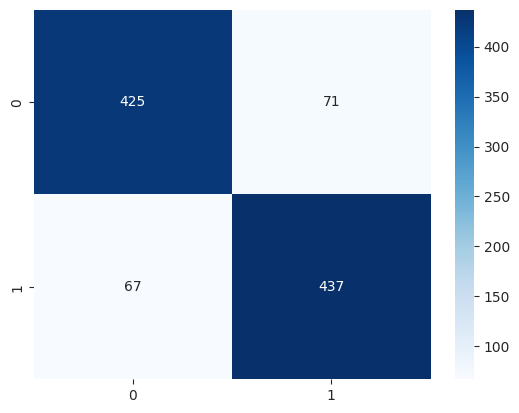

In [47]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.show()

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       496
           1       0.86      0.87      0.86       504

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000

